In [1]:
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns

import sys
sys.path.append('./..')
from refuelplot import *
setup()
sns.set_style("darkgrid")

from paths_nz import *

In [3]:
def read_NZprod():
    '''
    function for reading production data from csv
     read files per month separately and join
    '''
    years = range(1997,2020)
    months = range(1,13)
    for year in years:
        for month in months:
            try:
                prod_NZm = pd.read_csv(nz_path + "/generation/"+str(year)+f"{month:02d}"+"_Generation_MD.csv")
            except:
                continue
            if("prod_NZ" in locals()):
                prod_NZ = pd.concat([prod_NZ,prod_NZm[prod_NZm.Fuel_Code=="Wind"]])
            else:
                prod_NZ = prod_NZm[prod_NZm.Fuel_Code=="Wind"]
    return(prod_NZ)

def prep_gen(loc,prod_NZts):
    '''
    helper function for preparing productiond data
     selects data of one wind park loc
     transforms the trading periods to datetime format
     and aggregates data hourly
    '''
    prod_loc = prod_NZts[prod_NZts.POC_Gen==loc].drop(['POC_Gen','POC_Code'],axis=1)
    ind = pd.date_range(start=pd.to_datetime(prod_loc.Trading_date.values[0]),
                        freq='H',
                        periods=len(prod_loc.TP)/2,
                        tz='NZ').tz_convert('UTC').repeat(2)
    prod_loc = prod_loc.set_index(ind)
    prod_loch = prod_loc.prod_kW.resample('H').sum()
    return(prod_loch)

def rm_constTS(wpt,lim=24):
    '''
    function for removing constant parts of time series
     all series of more than lim (standard: 24 (hours))
     are removed from the dataset
    '''
    wpt1 = wpt.copy(deep=True)
    wpt1.index = wpt.index - np.timedelta64(1,'h')
    # starts of constant timeseries
    s = np.where((((wpt-wpt1).values[1:]==0).astype(int)-
                 ((wpt-wpt1).values[:-1]==0).astype(int))==1)[0]
    # ends of constant timeseries
    e = np.where((((wpt-wpt1).values[1:]==0).astype(int)-
                 ((wpt-wpt1).values[:-1]==0).astype(int))==-1)[0]
    # filter starts and ends of rows of constant that are longer than 24 hours
    sd = s[np.where((e-s)>lim)[0]]
    ed = e[np.where((e-s)>lim)[0]]
    rmdf = pd.Series(0,index=wpt.index)
    for i in range(len(sd)):
        rmdf.iloc[sd[i]:ed[i]] = 1
    return(wpt.where(rmdf==0))

def tidy_prod(prod_NZ):
    # bring from wide to tidy format
    prod_NZt = pd.melt(prod_NZ,
                       id_vars = ['POC_Code','Gen_Code','Trading_date'],
                       value_vars = ['TP' + str(i) for i in range(1,51)],
                       value_name="prod_kW").dropna()

    # extract number of trading period and sort
    prod_NZt['TP'] = [int(tp[2:]) for tp in prod_NZt.variable.values]
    prod_NZts = prod_NZt.sort_values(by=['POC_Code','Gen_Code','Trading_date','TP'])           
    # separate data by datetimeindex and location
    # as neither POC Codes (te rere hau & twf 3) nor Gen Codes (twf 12) are unique - combine to get unique values per location
    prod_NZts['POC_Gen'] = prod_NZts.Gen_Code + prod_NZts.POC_Code 
    prod_NZ = pd.Series(prod_NZts.POC_Gen.unique()).apply(prep_gen,args=(prod_NZts,)).transpose()
    prod_NZ.columns = prod_NZts.POC_Gen.unique()
    # sum up both west wind
    prod_NZ['west_wind'] = prod_NZ.west_windWWD1102 + prod_NZ.west_windWWD1103
    prod_NZ = prod_NZ.drop(['west_windWWD1102','west_windWWD1103'],axis=1)
    # associate wind park names
    # prod_NZ[1] probaly is twf 2 because it has mostly higher production than prod_NZ[0], which has lower installed capacity
    gen_wps = [n[:-7] for n in prod_NZ.columns]
    gen_wps[0] = "twf_1"
    gen_wps[1] = "twf_2"
    gen_wps[7] = "west_wind"
    prod_NZ.columns = gen_wps
    # remove constant parts of time series longer than one day
    prod_NZh = prod_NZ.apply(rm_constTS,axis=0)
    return(prod_NZh)

def load_results(dataset,gwa,parks):
    '''
    function for loading simulation results
     dataset is either MERRA2 or ERA5
     gwa is none, GWA2 or GWA3
     parks are the parkname codes
    '''
    if gwa == 'GWA2':
        rpath = results_path + '/results_GWA2/'
    else:
        rpath = results_path + '/'
    if gwa == 'none':
        file = 'windpower_NZ_'+dataset+'.nc'
    else:
        file = 'windpower_NZ_'+dataset+'_GWA.nc'
    NZ = xr.open_dataset(rpath + file).wp.to_dataframe().reset_index().set_index(['time','location']).unstack()
    # adapt datetime index of MERRA data (some hours are shifted by 30 min)
    if dataset == 'MERRA2':
        NZ.index.values[NZ.index.minute!=0] = NZ.index.values[NZ.index.minute!=0] - np.timedelta64(30,'m')
    # sum up Te Rere Hau and adapt names to generation data
    NZ = NZ.groupby(parks,axis=1).sum(axis=1).tz_localize('UTC')
    return(NZ)

def get_cap_df(cap,comdate):
    '''
    function for getting hourly capacities
     cap is numpy array of installed capacities
     comdate is numpy array of commissioning dates in datetime format
    '''
    com = pd.DataFrame({'capacity': cap}).groupby(comdate).sum()
    cap_cum = com.capacity.cumsum()
    # if only years given for commissioning dates -> gradual capacity increase over year, full capacity at end of year
    dr = pd.date_range('1/1/1997','31/12/2019 23:00:00',freq = 'h')
    cap_ts = pd.Series(dr.map(cap_cum),index = dr)
    cap_ts[0] = cap_cum[cap_cum.index<=pd.Timestamp('1997-01-01')].max()
    if type(comdate[0]) == np.int64:
        return(cap_ts.interpolate(method='linear'))
    else:
        return(cap_ts.fillna(method='ffill'))

def gcdH(park):
    '''
    function to get capacity time series for a wind park
    '''
    cap = windparks[parks==park].Capacity.values
    com = windparks[parks==park].commissioning.astype(np.datetime64).values
    cdf = get_cap_df(cap,com).tz_localize('UTC')
    cdf.name = park
    return(cdf)

def getph(park):
    '''
    analyse hourly wind power generation for one park
    '''
    comph = pd.DataFrame({'MERRA2':NZm[park],
                         'ERA5':NZe[park],
                         'MERRA2_GWA2':NZmg2[park],
                         'ERA5_GWA2':NZeg2[park],
                         'MERRA2_GWA3':NZmg3[park],
                         'ERA5_GWA3':NZeg3[park]})
    comph['obs'] = comph.index.map(prod_NZh[park])/1000
    # get capacities
    caph = capdfH[park]
    # calculate capacity factors
    cfh = comph.div(caph,axis=0)
    # remove capacity factors > 1
    cfh = cfh.mask(cfh>1).dropna()
    return(cfh)

def getNZh():
    '''
    analyse hourly wind power generation for NZ
    '''
    mask = (prod_NZh.notna()*capdfH.notna()).replace(0,np.nan)
    comph = pd.DataFrame({'MERRA2':(NZm*mask).sum(axis=1),
                         'ERA5':(NZe*mask).sum(axis=1),
                         'MERRA2_GWA2':(NZmg2*mask).sum(axis=1),
                         'ERA5_GWA2':(NZeg2*mask).sum(axis=1),
                         'MERRA2_GWA3':(NZmg3*mask).sum(axis=1),
                         'ERA5_GWA3':(NZeg3*mask).sum(axis=1)})
    comph['obs'] = comph.index.map((prod_NZh*mask).sum(axis=1))/1000
    # get capacities
    caph = (capdfH*mask).sum(axis=1)
    # calculate capacity factors
    cfh = comph.div(caph,axis=0)
    # remove capacity factors > 1
    cfh = cfh.mask(cfh>1).dropna()
    return(cfh)

def getpd(park):
    '''
    analyse daily wind power generation for one park
    '''
    mask = (prod_NZh[park].notna()*capdfH[park].notna()).replace(0,np.nan)
    comph = pd.DataFrame({'MERRA2':NZm[park]*mask,
                         'ERA5':NZe[park]*mask,
                         'MERRA2_GWA2':NZmg2[park]*mask,
                         'ERA5_GWA2':NZeg2[park]*mask,
                         'MERRA2_GWA3':NZmg3[park]*mask,
                         'ERA5_GWA3':NZeg3[park]*mask})
    comph['obs'] = comph.index.map(prod_NZh[park]*mask)/1000
    # get capacities and mask
    caph = capdfH[park]*mask
    # aggregate daily
    capd = caph.resample('D').sum()
    compd = comph.resample('D').sum()
    # calculate capacity factors
    cfd = compd.div(capd,axis=0)
    # remove capacity factors > 1
    cfd = cfd.mask(cfd>1).dropna()
    return(cfd)

def getNZd():
    '''
    analyse daily wind power generation for NZ
    '''
    # mask for masking simulated data and capacities
    # (to only use timespans where also observed data are available)
    mask = (prod_NZh.notna()*capdfH.notna()).replace(0,np.nan)
    # mask and aggregate simulated data
    comph = pd.DataFrame({'MERRA2':(NZm*mask).sum(axis=1),
                         'ERA5':(NZe*mask).sum(axis=1),
                         'MERRA2_GWA2':(NZmg2*mask).sum(axis=1),
                         'ERA5_GWA2':(NZeg2*mask).sum(axis=1),
                         'MERRA2_GWA3':(NZmg3*mask).sum(axis=1),
                         'ERA5_GWA3':(NZeg3*mask).sum(axis=1)})
    comph['obs'] = comph.index.map(prod_NZh.sum(axis=1))/1000
    # mask and aggregate capacities
    caph = (capdfH*mask).sum(axis=1)
    # aggregate daily
    compd = comph.resample('D').sum()
    capd = caph.resample('D').sum()
    # calculate capacity factors
    cfdu = compd.div(capd,axis=0).dropna()
    cfd = cfdu.mask(cfdu>1).dropna()
    return(cfd)

def getpm(park):
    '''
    analyse monthly wind power generation for one park
    '''
    # mask for masking simulated data and capacities
    # (to only use timespans where also observed data are available)
    mask = (prod_NZh[park].notna()*capdfH[park].notna()).replace(0,np.nan)
    comph = pd.DataFrame({'MERRA2':NZm[park]*mask,
                         'ERA5':NZe[park]*mask,
                         'MERRA2_GWA2':NZmg2[park]*mask,
                         'ERA5_GWA2':NZeg2[park]*mask,
                         'MERRA2_GWA3':NZmg3[park]*mask,
                         'ERA5_GWA3':NZeg3[park]*mask})
    comph['obs'] = comph.index.map(prod_NZh[park]*mask)/1000
    # get capacities and mask
    caph = capdfH[park]*mask
    # aggregate monthly
    capm = caph.resample('M').sum()
    compm = comph.resample('M').sum()
    # calculate capacity factors
    cfm = compm.div(capm,axis=0)
    # remove capacity factors > 1
    cfm = cfm.mask(cfm>1).dropna()
    return(cfm)

def getNZm():
    '''
    analyse monthly wind power generation for NZ
    '''
    # mask for masking simulated data and capacities
    # (to only use timespans where also observed data are available)
    mask = (prod_NZh.notna()*capdfH.notna()).replace(0,np.nan)
    # mask and aggregate simulated data
    comph = pd.DataFrame({'MERRA2':(NZm*mask).sum(axis=1),
                         'ERA5':(NZe*mask).sum(axis=1),
                         'MERRA2_GWA2':(NZmg2*mask).sum(axis=1),
                         'ERA5_GWA2':(NZeg2*mask).sum(axis=1),
                         'MERRA2_GWA3':(NZmg3*mask).sum(axis=1),
                         'ERA5_GWA3':(NZeg3*mask).sum(axis=1)})
    comph['obs'] = comph.index.map(prod_NZh.sum(axis=1))/1000
    # mask and aggregate capacities
    caph = (capdfH*mask).sum(axis=1)
    # aggregate monthly
    compm = comph.resample('M').sum()
    capm = caph.resample('M').sum()
    # calculate capacity factors
    cfmu = compm.div(capm,axis=0).dropna()
    cfm = cfmu.mask(cfmu>1).dropna()
    return(cfm)

def tidy_res(results,temp,scale):
    '''
    function for preparing results for merging
     results are results in wide format (one region per line)
     temp is temporal resolution (h,d,m)
     scale is spatial resoltion (park or country)
    '''
    rt = results.transpose().reset_index().melt(id_vars=['param','dataset'], 
                                                value_vars=results.index, var_name='location')
    ts = pd.DataFrame({'temp':temp,'scale':scale},
                      index = range(reduce(mul,results.shape)))
    return(pd.concat([rt,ts],axis=1))

In [4]:
## Analysis
# load windpark data
print('prepare windparks')
windparks = pd.read_csv(nz_path + "/windparks_NZ.csv", delimiter=';', parse_dates=['commissioning'])
# dictionary for matching data
d = {'twf1':'twf_1',
     'twf2':'twf_2',
     'twf3':'twf_3',
     'Te Apiti':'te_apiti',
     'Te Rere Hau1':'te_rere_hau',
     'Te Rere Hau2':'te_rere_hau',
     'Te Rere Hau3':'te_rere_hau',
     'Te Uku':'te_uku',
     'White Hill Wind Farm':'white_hill',
     'Westwind Wind Farm':'west_wind'}
# match wind park names
parks = (windparks.ProjectName + windparks.stage.astype(str).replace({'0':''})).replace(d).values

# load observed data
print('load observed data')
prod_NZh = tidy_prod(read_NZprod())

# get capacitiy time series for all parks
print('get capacities')
pu = np.unique(parks)
capdfH = pd.Series(pu,index = pu).apply(gcdH).transpose()

prepare windparks
load observed data
get capacities


In [5]:
# load simulated data
print('load simulated data')
NZm = load_results('MERRA2','none',parks)
NZmg2 = load_results('MERRA2','GWA2',parks)
NZmg3 = load_results('MERRA2','GWA3',parks)
NZe = load_results('ERA5','none',parks)
NZeg2 = load_results('ERA5','GWA2',parks)
NZeg3 = load_results('ERA5','GWA3',parks)

load simulated data


In [6]:
NZH = getNZh()
NZM = getNZm()

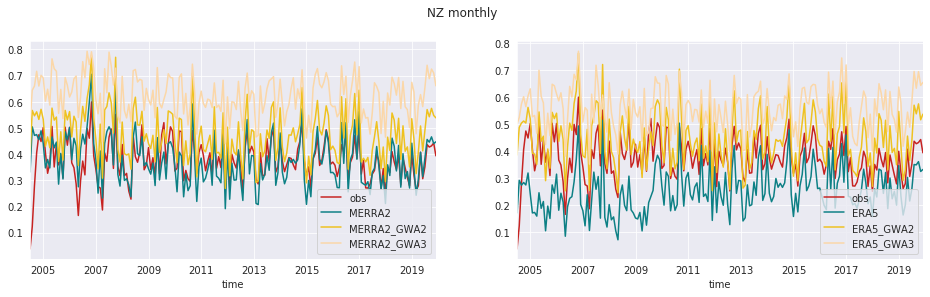

In [14]:
fig, axs = plt.subplots(1,2,figsize=(16,4))
fig.suptitle('NZ monthly',y=1.001)
sims = [['obs','MERRA2','MERRA2_GWA2','MERRA2_GWA3'],['obs','ERA5','ERA5_GWA2','ERA5_GWA3']]
for i in range(len(sims)):
    NZM[sims[i]].plot(ax = axs[i])

In [17]:
pM = pd.Series(np.unique(parks)).apply(getpm)

In [ ]:
fig, axs = plt.subplots(8,2,figsize=(16,32))
fig.suptitle('NZ parks monthly',y=0.99)
sims = [['obs','MERRA2','MERRA2_GWA2','MERRA2_GWA3'],['obs','ERA5','ERA5_GWA2','ERA5_GWA3']]
for p in range(len(pM)):
    for i in range(len(sims)):
        pM[p][sims[i]].plot(ax = axs[p,i]).set_title(pd.Series(np.unique(parks))[p])
fig.tight_layout(pad=1.5)

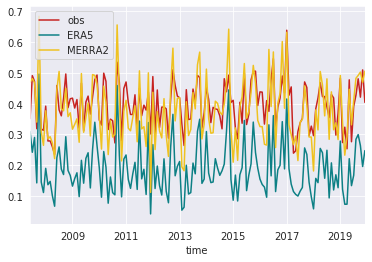

In [53]:
pM[5].iloc[4:][['obs','ERA5','MERRA2']].plot()

In [7]:
def reduce_monthsH(parkn,sim,nmonths,pr=True):
    y = pH[parkn].ERA5.index[0].year
    m = pH[parkn].ERA5.index[0].month
    mo = m + nmonths
    if(mo>12):
        y = y + int(mo / 12)
        mo = mo % 12
        if mo == 0:
            mo = 12
    c = pd.to_datetime(str(y) + '-' + str(mo))
    ss = pH[parkn][c:][sim]
    so = pH[parkn][c:].obs
    ls = pH[parkn][sim]
    lo = pH[parkn].obs
    s = round(np.corrcoef(ss,so)[0,1],3)
    l = round(np.corrcoef(ls,lo)[0,1],3)
    sr = round(((ss-so)**2).mean()**0.5,3)
    lr = round(((ls-lo)**2).mean()**0.5,3)
    if pr:
        print('correlation\nshorter:',s, 'normal:',l, 'diff:',round(s-l,3))
        print('RMSE\nshorter:',sr, 'normal:',lr, 'diff:',round(sr-lr,3))
    else:
        return([s,l,sr,lr])

In [8]:
def reduce_monthsD(parkn,sim,nmonths,pr=True):
    y = pD[parkn].ERA5.index[0].year
    m = pD[parkn].ERA5.index[0].month
    mo = m + nmonths
    if(mo>12):
        y = y + int(mo / 12)
        mo = mo % 12
        if mo == 0:
            mo = 12
    c = pd.to_datetime(str(y) + '-' + str(mo))
    ss = pD[parkn][c:][sim]
    so = pD[parkn][c:].obs
    ls = pD[parkn][sim]
    lo = pD[parkn].obs
    s = round(np.corrcoef(ss,so)[0,1],3)
    l = round(np.corrcoef(ls,lo)[0,1],3)
    sr = round(((ss-so)**2).mean()**0.5,3)
    lr = round(((ls-lo)**2).mean()**0.5,3)
    if pr:
        print('correlation\nshorter:',s, 'normal:',l, 'diff:',round(s-l,3))
        print('RMSE\nshorter:',sr, 'normal:',lr, 'diff:',round(sr-lr,3))
    else:
        return([s,l,sr,lr])

In [9]:
def reduce_monthsM(parkn,sim,nmonths,pr=True):
    y = pM[parkn].ERA5.index[0].year
    m = pM[parkn].ERA5.index[0].month
    mo = m + nmonths
    if(mo>12):
        y = y + int(mo / 12)
        mo = mo % 12
        if mo == 0:
            mo = 12
    c = pd.to_datetime(str(y) + '-' + str(mo))
    ss = pM[parkn][c:][sim]
    so = pM[parkn][c:].obs
    ls = pM[parkn][sim]
    lo = pM[parkn].obs
    s = round(np.corrcoef(ss,so)[0,1],3)
    l = round(np.corrcoef(ls,lo)[0,1],3)
    sr = round(((ss-so)**2).mean()**0.5,3)
    lr = round(((ls-lo)**2).mean()**0.5,3)
    if pr:
        print('correlation\nshorter:',s, 'normal:',l, 'diff:',round(s-l,3))
        print('RMSE\nshorter:',sr, 'normal:',lr, 'diff:',round(sr-lr,3))
    else:
        return([s,l,sr,lr])

In [10]:
parksu = pd.Series(parks).unique()

### hourly

In [13]:
pH = pd.Series(np.unique(parks)).apply(getph)

In [324]:
ch = []
rh = []
for p in range(len(pH)):
    c0 = []
    r0 = []
    for i in range(20):
        rm = reduce_monthsH(p,'ERA5',i,pr=False)
        c0 = c0 + [rm[0]]
        r0 = r0 + [rm[2]]
    ch = ch + [c0]
    rh = rh + [r0]

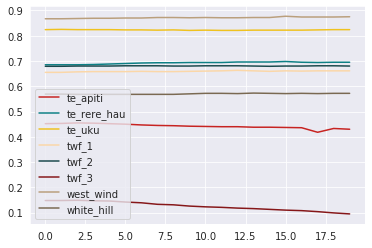

In [325]:
for i in range(len(ch)):
    plt.plot(ch[i],label=parksu[i])
plt.legend()

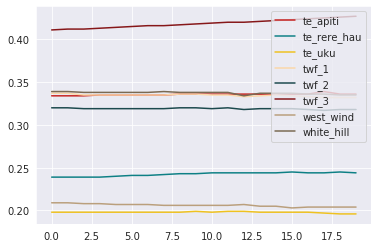

In [326]:
for i in range(len(rh)):
    plt.plot(rh[i],label=parksu[i])
plt.legend()

### daily

In [14]:
pD = pd.Series(np.unique(parks)).apply(getpd)

In [328]:
cd = []
rd = []
for p in range(len(pH)):
    c0 = []
    r0 = []
    for i in range(20):
        rm = reduce_monthsD(p,'ERA5',i,pr=False)
        c0 = c0 + [rm[0]]
        r0 = r0 + [rm[2]]
    cd = cd + [c0]
    rd = rd + [r0]

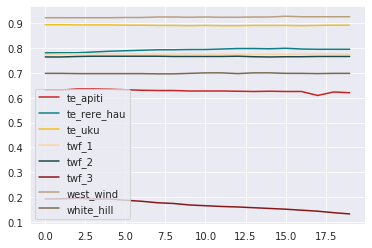

In [329]:
for i in range(len(cd)):
    plt.plot(cd[i],label=parksu[i])
plt.legend()

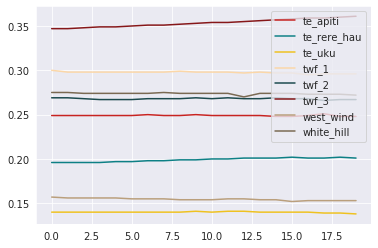

In [330]:
for i in range(len(rd)):
    plt.plot(rd[i],label=parksu[i])
plt.legend()

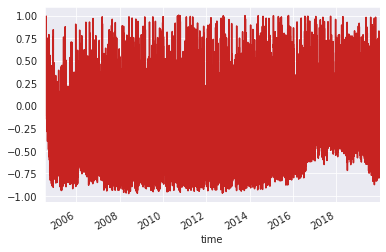

In [331]:
(pH[0].ERA5-pH[0].obs).plot()

### monthly

In [332]:
cm = []
rmm = []
for p in range(len(pH)):
    c0 = []
    r0 = []
    for i in range(20):
        rm = reduce_monthsM(p,'ERA5',i,pr=False)
        c0 = c0 + [rm[0]]
        r0 = r0 + [rm[2]]
    cm = cm + [c0]
    rmm = rmm + [r0]

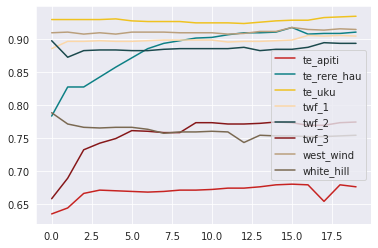

In [333]:
for i in range(len(cm)):
    plt.plot(cm[i],label=parksu[i])
plt.legend()

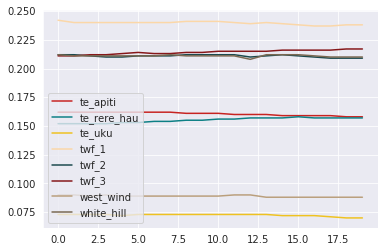

In [334]:
for i in range(len(rmm)):
    plt.plot(rmm[i],label=parksu[i])
plt.legend()

## monthly different simulations - cut at ~ 5 months increases quality

In [375]:
def compM(dataset):
    c = []
    r = []
    for p in range(len(pM)):
        c0 = []
        r0 = []
        for i in range(20):
            rm = reduce_monthsM(p,dataset,i,pr=False)
            c0 = c0 + [rm[0]]
            r0 = r0 + [rm[2]]
        c = c + [c0]
        r = r + [r0]
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,4.5))
    for i in range(len(c)):
        ax1.plot(range(20),c[i])
        ax2.plot(range(20),r[i],label=parksu[i])
    ax1.set_title('correlations')
    ax2.set_title('RMSEs')
    plt.legend()

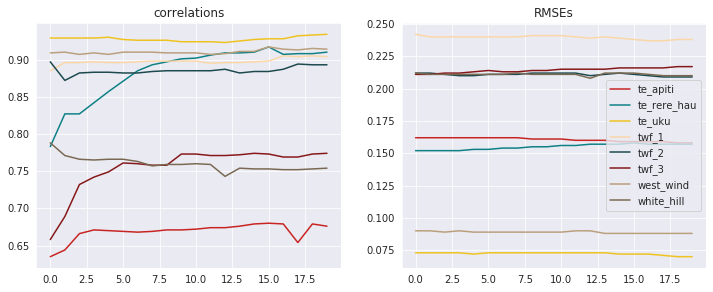

In [376]:
compM('ERA5')

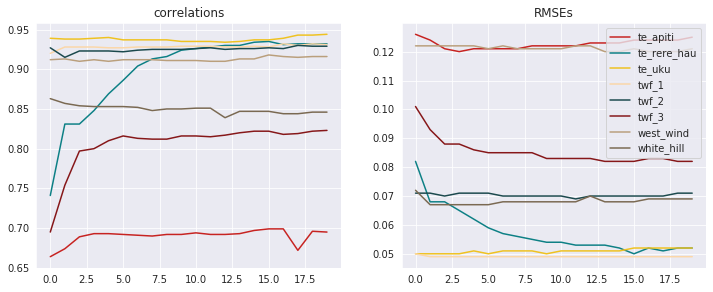

In [377]:
compM('ERA5_GWA2')

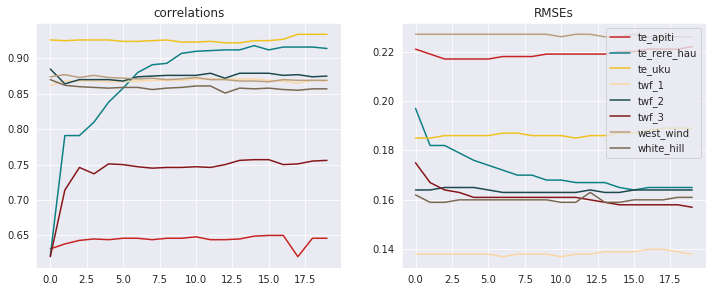

In [378]:
compM('ERA5_GWA3')

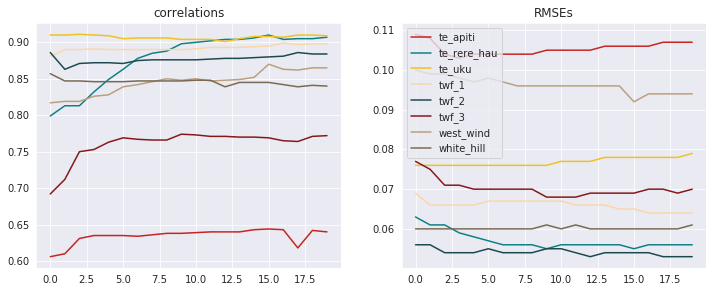

In [379]:
compM('MERRA2')

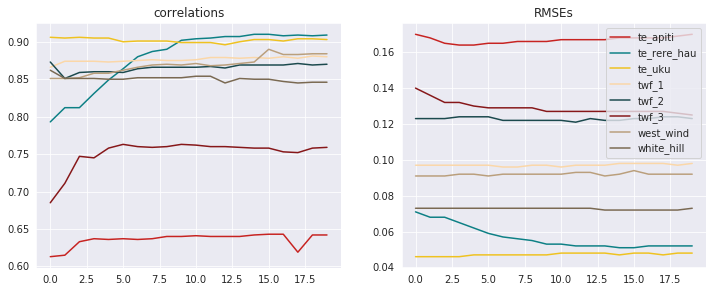

In [380]:
compM('MERRA2_GWA2')

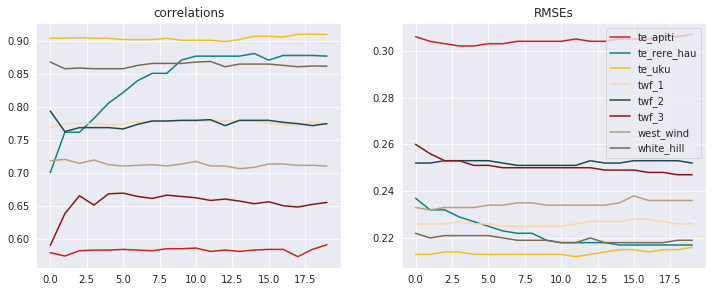

In [381]:
compM('MERRA2_GWA3')

## hourly different simulations - cut irrelevant
twf_3 always bad

In [15]:
def compH(dataset):
    c = []
    r = []
    for p in range(len(pH)):
        c0 = []
        r0 = []
        for i in range(20):
            rm = reduce_monthsH(p,dataset,i,pr=False)
            c0 = c0 + [rm[0]]
            r0 = r0 + [rm[2]]
        c = c + [c0]
        r = r + [r0]
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,4.5))
    for i in range(len(c)):
        ax1.plot(range(20),c[i])
        ax2.plot(range(20),r[i],label=parksu[i])
    ax1.set_title('correlations')
    ax2.set_title('RMSEs')
    plt.legend()

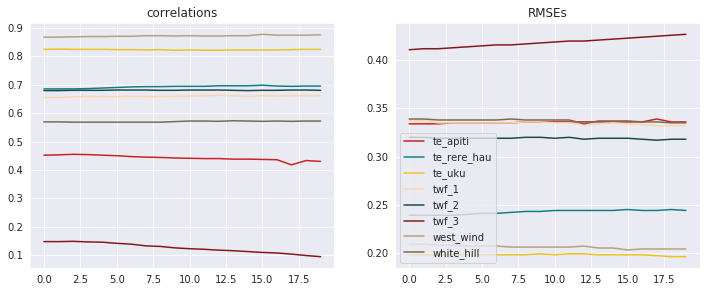

In [16]:
compH('ERA5')

In [ ]:
pH[5][['ERA5_GWA3','obs']].plot.box()

In [ ]:
compH('ERA5_GWA2')

In [ ]:
compH('ERA5_GWA3')

In [ ]:
compH('MERRA2')

In [ ]:
compH('MERRA2_GWA2')

In [ ]:
compH('MERRA2_GWA3')

## daily different simulations - cut irrelevant
twf_3 always bad

In [390]:
def compD(dataset):
    c = []
    r = []
    for p in range(len(pD)):
        c0 = []
        r0 = []
        for i in range(20):
            rm = reduce_monthsD(p,dataset,i,pr=False)
            c0 = c0 + [rm[0]]
            r0 = r0 + [rm[2]]
        c = c + [c0]
        r = r + [r0]
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,4.5))
    for i in range(len(c)):
        ax1.plot(range(20),c[i])
        ax2.plot(range(20),r[i],label=parksu[i])
    ax1.set_title('correlations')
    ax2.set_title('RMSEs')
    plt.legend()

In [ ]:
compD('ERA5')

In [ ]:
compD('ERA5_GWA2')

In [ ]:
compD('ERA5_GWA3')

In [ ]:
compD('MERRA2')

In [ ]:
compD('MERRA2_GWA2')

In [ ]:
compD('MERRA2_GWA3')

why twf3 so bad?

Text(0.5, 1.0, 'te_apiti')

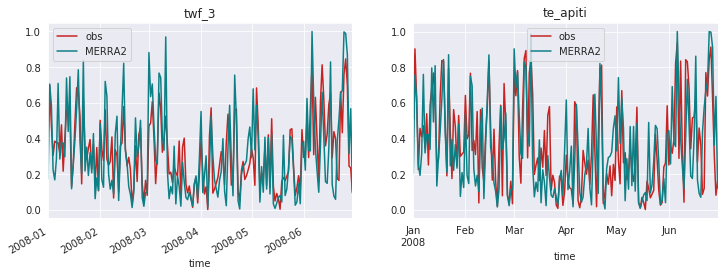

In [426]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
pD[5][['obs','MERRA2']]['2008':'2008-06'].plot(ax=ax1)
pD[0][['obs','MERRA2']]['2008':'2008-06'].plot(ax=ax2)
ax1.set_title(parksu[5])
ax2.set_title(parksu[0])

Text(0.5, 1.0, 'te_apiti')

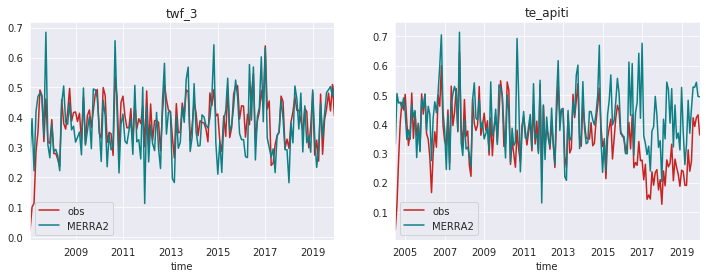

In [425]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
pM[5][['obs','MERRA2']].plot(ax=ax1)
pM[0][['obs','MERRA2']].plot(ax=ax2)
ax1.set_title(parksu[5])
ax2.set_title(parksu[0])